<a href="https://colab.research.google.com/github/NoobDip/Handwritten_Digit_Recognition/blob/main/HandWrittenDigit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])

train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [16]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


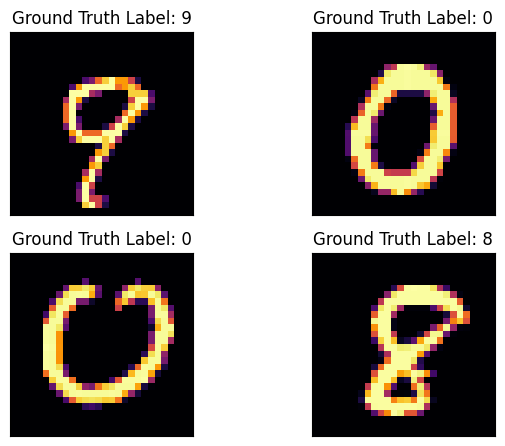

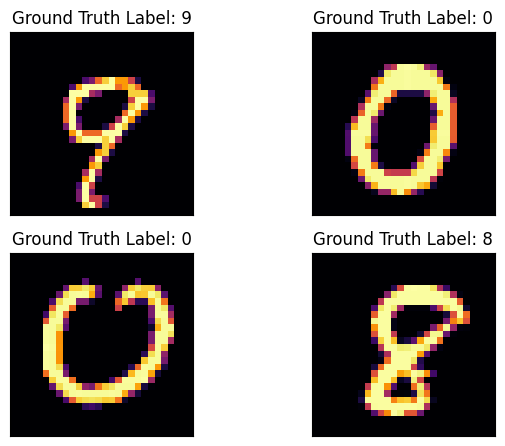

In [17]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [18]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutaional_neural_network_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [21]:
epochs = 10

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        model.eval()
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:

                images = images.to(device)
                labels = labels.to(device)

                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels).item()

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor)).item()

        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.7964   Testing loss: 0.2781   Test accuracy: 0.9155  
Epoch: 2/10   Training loss: 0.2706   Testing loss: 0.1641   Test accuracy: 0.9464  
Epoch: 3/10   Training loss: 0.1860   Testing loss: 0.1187   Test accuracy: 0.9626  
Epoch: 4/10   Training loss: 0.1397   Testing loss: 0.0812   Test accuracy: 0.9759  
Epoch: 5/10   Training loss: 0.1161   Testing loss: 0.0759   Test accuracy: 0.9742  
Epoch: 6/10   Training loss: 0.1008   Testing loss: 0.0676   Test accuracy: 0.9790  
Epoch: 7/10   Training loss: 0.0911   Testing loss: 0.0605   Test accuracy: 0.9814  
Epoch: 8/10   Training loss: 0.0818   Testing loss: 0.0576   Test accuracy: 0.9803  
Epoch: 9/10   Training loss: 0.0759   Testing loss: 0.0519   Test accuracy: 0.9836  
Epoch: 10/10   Training loss: 0.0714   Testing loss: 0.0470   Test accuracy: 0.9852  


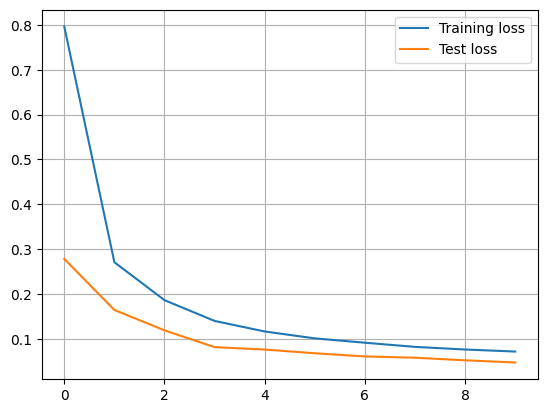

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [23]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[5.9308979e-05 1.1587194e-07 5.8478338e-04 2.6522748e-05 4.1524193e-09
 1.1280957e-06 3.0577490e-07 3.3695534e-07 9.9931085e-01 1.6655782e-05]


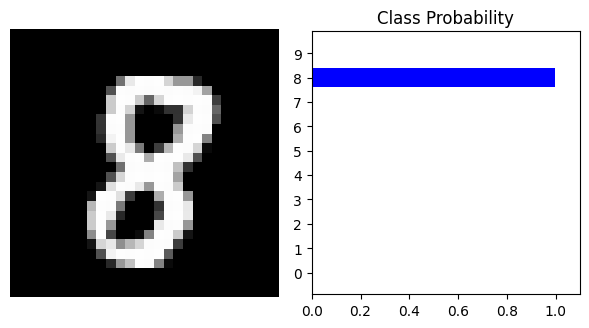

In [27]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='gray')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='b' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()